# Energy Forecasting - Model Training

In this notebook:
- Load preprocessed hourly power consumption data
- Create time-based features
- Train regression models (Linear Regression, LightGBM)
- Evaluate model performance

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

df = pd.read_csv("data/hourly_power_consumption.csv", parse_dates=["Datetime"])
df.set_index("Datetime", inplace=True)
df = df.dropna(subset=["Global_active_power"])

class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        if isinstance(X, pd.DataFrame) and isinstance(X_.index, pd.DatetimeIndex):
            X_["hour"] = X_.index.hour
            X_["day"] = X_.index.day
            X_["weekday"] = X_.index.weekday
            X_["month"] = X_.index.month
        return X_[['hour', 'day', 'weekday', 'month']]

y = df['Global_active_power']
X = df.drop(columns=['Global_active_power'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Baseline model (Linear Regression)
print("Training Linear Regression model...")
feature_gen = TimeFeatureGenerator()
X_train_feat = feature_gen.transform(X_train)
X_test_feat = feature_gen.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train_feat, y_train)
y_pred_baseline = baseline_model.predict(X_test_feat)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline (Linear Regression): MAE: {mae_baseline:.3f} | RMSE: {rmse_baseline:.3f}")

Training Linear Regression model...
Baseline (Linear Regression): MAE: 0.585 | RMSE: 0.720


In [15]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

lgbm_pipeline = Pipeline([
    ('feature_gen', TimeFeatureGenerator()),
    ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

print("LightGBM Pipeline training...")
lgbm_pipeline.fit(X_train, y_train)

# predictions and save
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# save model
joblib.dump(lgbm_pipeline, 'model.joblib')

# compare performances

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("-" * 30)
print(f"LightGBM MAE: {mae_lgbm:.3f}")
print(f"LightGBM RMSE: {rmse_lgbm:.3f}")

print(f"Improvment: {((mae_baseline - mae_lgbm) / mae_baseline) * 100:.1f}% reduction in error.")
print("-" * 30)

LightGBM Pipeline training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 27334, number of used features: 4
[LightGBM] [Info] Start training from score 1.110571
------------------------------
LightGBM MAE: 0.440
LightGBM RMSE: 0.603
Improvment: 24.8% reduction in error.
------------------------------


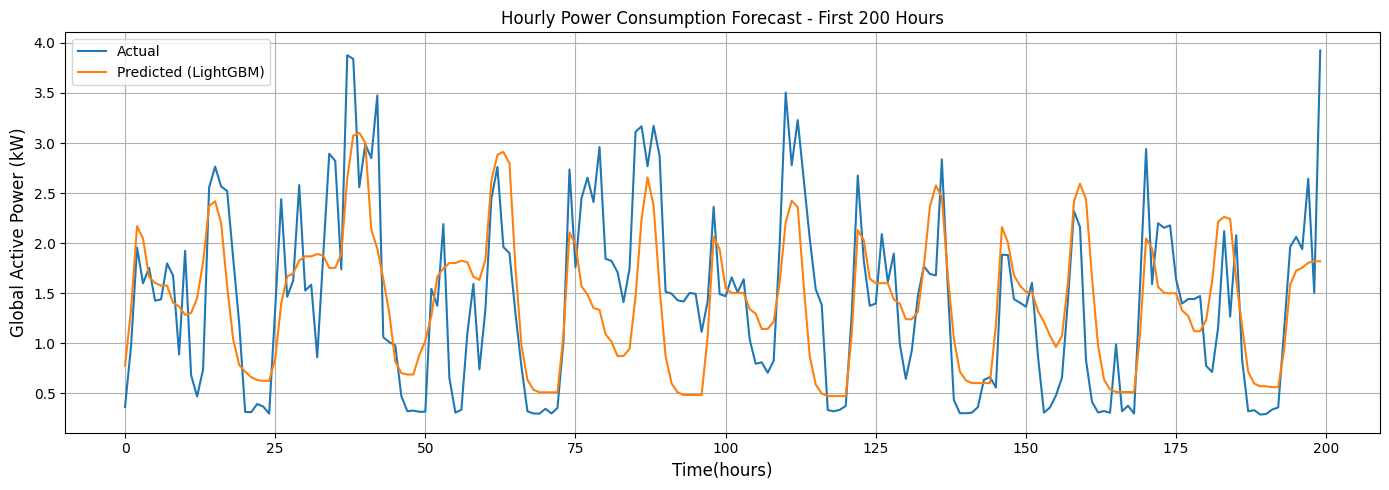

In [3]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted (LightGBM)')
plt.title("Hourly Power Consumption Forecast - First 200 Hours")
plt.xlabel("Time(hours)", fontsize=12)
plt.ylabel("Global Active Power (kW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()